# Analyzing how coherence scales with model size

## Importing libraries and loading data

In [1]:
from src.analyzer import Analyzer
from src.visualizer import VisualisationConfig, visualize
from src.metrics import pairwise_bce_of_group
import altair as alt
import numpy as np
import pandas as pd

alt.data_transformers.enable("vegafusion")

logprob_data_path = "data/logprobs.csv"
pythia_data_path = "data/pythia_logprobs.csv"

# merge logprobs.csv and pythia_logprobs.csv
logprobs = pd.read_csv(logprob_data_path)
pythia_logprobs = pd.read_csv(pythia_data_path)

# merge the two dataframes
logprobs = pd.concat([logprobs, pythia_logprobs])


data_analyzer = Analyzer(logprobs)
data_analyzer.df

,item_index,class_type,class,class_elicitation,evidence_category,evidence_text,evidence_elicitation,conversation_history,model_name,model_provider,...,posterior_prob,prior_prompt,likelihood_prompt,posterior_prompt,prior_full_text,likelihood_full_text,posterior_full_text,prior_token_logprobs,likelihood_token_logprobs,posterior_token_logprobs
0,0,novelists,William Shakespeare.,My favourite author is,literary_analysis,works that bring out the contemporary social ...,I prefer reading,We've been discussing literary styles and hist...,meta-llama/Llama-3.1-8B,hf,...,0.002039,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,"[-3.5479869842529297, -0.7962633371353149, -0....","[-5.289000511169434, -2.5782995223999023, -6.3...","[-3.8323044776916504, -0.995391845703125, -1.3..."
1,0,novelists,William Shakespeare.,My favourite author is,literary_analysis,character-driven narratives.,I prefer reading,We've been discussing literary styles and hist...,meta-llama/Llama-3.1-8B,hf,...,0.001275,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,"[-3.5479869842529297, -0.7962633371353149, -0....","[-10.583301544189453, -1.8038426637649536, -3....","[-4.018360137939453, -1.8006072044372559, -0.8..."
2,0,novelists,William Shakespeare.,My favourite author is,historical_context,literature from periods of significant social...,I prefer reading,We've been discussing literary styles and hist...,meta-llama/Llama-3.1-8B,hf,...,0.000455,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,"[-3.5479869842529297, -0.7962633371353149, -0....","[-4.2250213623046875, -2.044250965118408, -7.6...","[-4.17518424987793, -1.5934702157974243, -1.92..."
3,0,novelists,William Shakespeare.,My favourite author is,historical_context,social observers.,I prefer reading,We've been discussing literary styles and hist...,meta-llama/Llama-3.1-8B,hf,...,0.000438,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,"[-3.5479869842529297, -0.7962633371353149, -0....","[-10.307802200317383, -12.089680671691895, -2....","[-4.350062847137451, -2.5824971199035645, -0.8..."
4,0,novelists,William Shakespeare.,My favourite author is,cultural_impact,books that challenged conventional thinking a...,I prefer reading,We've been discussing literary styles and hist...,meta-llama/Llama-3.1-8B,hf,...,0.001370,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,"[-3.5479869842529297, -0.7962633371353149, -0....","[-3.743206024169922, -2.3469152450561523, -11....","[-4.11558723449707, -1.5119941234588623, -0.96..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,7,travel_preferences,luxury travel.,My travel style is best described as,financial_insight,innovative financing solutions enable more fl...,I find that traveling by,We've been

## Renaming columns, models and adding model family and size columns

In [2]:
np.unique(data_analyzer.df["model_name"]), np.unique(data_analyzer.df["model_kwargs"])

(array(['EleutherAI/pythia-12b', 'EleutherAI/pythia-160m',
        'EleutherAI/pythia-1b', 'EleutherAI/pythia-6.9b',
        'meta-llama/Llama-3.1-8B', 'meta-llama/Llama-3.2-1B',
        'meta-llama/Llama-3.2-3B', 'openai-community/gpt2',
        'openai-community/gpt2-large', 'openai-community/gpt2-medium',
        'openai-community/gpt2-xl'], dtype=object),
 array(['{"revision": "step143000"}', '{"revision": "step33000"}',
        '{"revision": "step66000"}', '{"revision": "step99000"}', '{}'],
       dtype=object))

In [3]:
data_analyzer.rename({"model_name": "Language Model", "model_kwargs": "Training Steps"})

data_analyzer.add_column(
    column_name="Model Family",
    column_spec=(
        {"Language Model": lambda model_name: model_name.split("/")[1].split("-")[0]}
    ),
)


def format_model_kwargs(kwarg_str):
    if '"revision": "step' in kwarg_str:
        # Extract the step number
        step = kwarg_str.split("step")[1].split('"')[0]
        # Convert to k format (e.g., 33000 -> 33k)
        step_k = str(int(step) // 1000) + "k"
        return step_k
    else:
        return "unknown"


data_analyzer.rename(
    {
        "Model Family": {
            "Llama": "Llama 3",
            "gpt2": "GPT 2",
            "pythia": "Pythia",
        },
        "Language Model": {
            "openai-community/gpt2": "GPT-2-S",
            "openai-community/gpt2-medium": "GPT-2-M",
            "openai-community/gpt2-large": "GPT-2-L",
            "openai-community/gpt2-xl": "GPT-2-XL",
            "meta-llama/Llama-3.2-1B": "Llama3.2-1B",
            "meta-llama/Llama-3.2-3B": "Llama3.2-3B",
            "meta-llama/Llama-3.1-8B": "Llama3.1-8B",
            "EleutherAI/pythia-160m": "Pythia-160M",
            "EleutherAI/pythia-1b": "Pythia-1B",
            "EleutherAI/pythia-6.9b": "Pythia-6.9B",
            "EleutherAI/pythia-12b": "Pythia-12B",
        },
        "Training Steps": format_model_kwargs,
    }
)

data_analyzer.add_column(
    column_name="Model Size",
    column_spec=(
        {
            "Language Model": {
                "GPT-2-S": 1.24e8,
                "GPT-2-M": 3.55e8,
                "GPT-2-L": 7.74e8,
                "GPT-2-XL": 1.5e9,
                "Llama3.2-1B": 1.23e9,
                "Llama3.2-3B": 3.21e9,
                "Llama3.1-8B": 8.03e9,
                "Pythia-160M": 1.6e8,
                "Pythia-1B": 1.0e9,
                "Pythia-6.9B": 6.9e9,
                "Pythia-12B": 1.2e10,
            }
        }
    ),
)

data_analyzer.df

,item_index,class_type,class,class_elicitation,evidence_category,evidence_text,evidence_elicitation,conversation_history,Language Model,model_provider,...,likelihood_prompt,posterior_prompt,prior_full_text,likelihood_full_text,posterior_full_text,prior_token_logprobs,likelihood_token_logprobs,posterior_token_logprobs,Model Family,Model Size
0,0,novelists,William Shakespeare.,My favourite author is,literary_analysis,works that bring out the contemporary social ...,I prefer reading,We've been discussing literary styles and hist...,Llama3.1-8B,hf,...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,"[-3.5479869842529297, -0.7962633371353149, -0....","[-5.289000511169434, -2.5782995223999023, -6.3...","[-3.8323044776916504, -0.995391845703125, -1.3...",Llama 3,8.030000e+09
1,0,novelists,William Shakespeare.,My favourite author is,literary_analysis,character-driven narratives.,I prefer reading,We've been discussing literary styles and hist...,Llama3.1-8B,hf,...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,"[-3.5479869842529297, -0.7962633371353149, -0....","[-10.583301544189453, -1.8038426637649536, -3....","[-4.018360137939453, -1.8006072044372559, -0.8...",Llama 3,8.030000e+09
2,0,novelists,William Shakespeare.,My favourite author is,historical_context,literature from periods of significant social...,I prefer reading,We've been discussing literary styles and hist...,Llama3.1-8B,hf,...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,"[-3.5479869842529297, -0.7962633371353149, -0....","[-4.2250213623046875, -2.044250965118408, -7.6...","[-4.17518424987793, -1.5934702157974243, -1.92...",Llama 3,8.030000e+09
3,0,novelists,William Shakespeare.,My favourite author is,historical_context,social observers.,I prefer reading,We've been discussing literary styles and hist...,Llama3.1-8B,hf,...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,"[-3.5479869842529297, -0.7962633371353149, -0....","[-10.307802200317383, -12.089680671691895, -2....","[-4.350062847137451, -2.5824971199035645, -0.8...",Llama 3,8.030000e+09
4,0,novelists,William Shakespeare.,My favourite author is,cultural_impact,books that challenged conventional thinking a...,I prefer reading,We've been discussing literary styles and hist...,Llama3.1-8B,hf,...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,"[-3.5479869842529297, -0.7962633371353149, -0....","[-3.743206024169922, -2.3469152450561523, -11....","[-4.11558723449707, -1.5119941234588623, -0.96...",Llama 3,8.030000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,7,travel_preferences,luxury travel.,My travel style is best described as,financial_insight,innovative financing solutions enable more fl...,I find that traveling by,We've been sharing our memorable journeys and ...,Pythia-12B,hf,...,We've been sharing our memorable journeys and ...,We've been sharing our memorable journeys and ...,We've been sharing our memorable journeys and ...,We've been sharing our memorable journeys 

## Calculating BCE (both MSE and MAE methods)

We always group by evidence_text since different class types have different class and evidence elicitation prefixes.

The calculate_metric functions are unique in that they return an Analyzer object rather than modifying the dataframe in place. This allows calculating multiple metrics on the same dataframe. Since the returned object is an Analyzer, we can continue to filter, sort, rename and add columns. 

In [4]:
bce_mse_analyzer = data_analyzer.calculate_metric(
    metric_name="BCE (Pairwise MSE)",
    metric_func=pairwise_bce_of_group,
    group_by_cols=["evidence_text", "class_type", "Language Model", "Training Steps"],
    log_prior_col="prior_logprob",
    log_likelihood_col="likelihood_logprob",
    log_posterior_col="posterior_logprob",
    square=True,
    inherit_identical_values=True,
)

bce_mae_analyzer = data_analyzer.calculate_metric(
    metric_name="BCE (Pairwise MAE)",
    metric_func=pairwise_bce_of_group,
    group_by_cols=[ "evidence_text", "class_type", "Language Model", "Training Steps"],
    log_prior_col="prior_logprob",
    log_likelihood_col="likelihood_logprob",
    log_posterior_col="posterior_logprob",
    square=False,
    inherit_identical_values=True,
)

# Set sort order using the *new* names
for analyzer in [bce_mse_analyzer, bce_mae_analyzer]:
    analyzer.sort(
        {
            "Language Model": [
                "GPT-2-S",
                "GPT-2-M",
                "GPT-2-L",
                "GPT-2-XL",
                "Llama3.2-1B",
                "Llama3.2-3B",
                "Llama3.1-8B",
                "Pythia-160M",
                "Pythia-1B",
                "Pythia-6.9B",
                "Pythia-12B",
            ],
            "Training Steps": [
                "33k",
                "66k",
                "99k",
                "143k",
                "unknown",
            ],
        }
    )

bce_mse_analyzer.df

,evidence_text,class_type,Language Model,Training Steps,BCE (Pairwise MSE),item_index,class_elicitation,evidence_category,evidence_elicitation,conversation_history,model_provider,temperature,device,model_params,likelihood_num_tokens,prior_prompt,posterior_prompt,Model Family,Model Size
20,a disciplined focus on valuation uncovers und...,financial_strategies,GPT-2-S,unknown,0.072817,6,My investment strategy aligns with,financial_insight,I base my financial decisions on,We've been analyzing various investment approa...,hf,1.0,cuda,"{""batch_size"": 64}",13,We've been analyzing various investment approa...,We've been analyzing various investment approa...,GPT 2,1.240000e+08
21,a disciplined focus on valuation uncovers und...,financial_strategies,GPT-2-S,unknown,0.883913,6,My investment strategy aligns with,financial_insight,I base my financial decisions on,We've been analyzing various investment approa...,hf,1.0,cuda,"{""batch_size"": 64}",13,We've been analyzing various investment approa...,We've been analyzing various investment approa...,GPT 2,1.240000e+08
22,a disciplined focus on valuation uncovers und...,financial_strategies,GPT-2-S,unknown,0.030477,6,My investment strategy aligns with,financial_insight,I base my financial decisions on,We've been analyzing various investment approa...,hf,1.0,cuda,"{""batch_size"": 64}",13,We've been analyzing various investment approa...,We've been analyzing various investment approa...,GPT 2,1.240000e+08
23,a disciplined focus on valuation uncovers und...,financial_strategies,GPT-2-S,unknown,0.455928,6,My investment strategy aligns with,financial_insight,I base my financial decisions on,We've been analyzing various investment approa...,hf,1.0,cuda,"{""batch_size"": 64}",13,We've been analyzing various investment approa...,We've been analyzing various investment approa...,GPT 2,1.240000e+08
24,a disciplined focus on valuation uncovers und...,financial_strategies,GPT-2-S,unknown,0.449330,6,My investment strategy aligns with,financial_insight,I base my financial decisions on,We've been analyzing various investment approa...,hf,1.0,cuda,"{""batch_size"": 64}",13,We've been analyzing various investment approa...,We've been analyzing various investment approa...,GPT 2,1.240000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8953,works that bring out the contemporary social ...,novelists,Pythia-12B,143k,0.282647,0,My favourite author is,literary_analysis,I prefer reading,We've been discussing literary styles and hist...,hf,1.0,cuda,"{""batch_size"": 32}",24,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,Pythia,1.200000e+10
8954,works that bring out the contemporary social ...,novelists,Pythia-12B,143k,0.002906,0,My favourite author is,literary_analysis,I prefer reading,We've been discussing literary styles and hist...,hf,1.0,cuda,"{""batch_size"": 32}",24,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,Pythia,1.200000e+10
8955,works that bring out the contemporary social ...,novelists,Pythia-12B,143k,18.148981,0,My favourite author is,literary_analysis,I prefer reading,We've been discussing literary styles and hist...,hf,1.0,cuda,"{""batch_size"": 32}",24,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,Pythia,1.200000e+10
8956,works that bring out the contemporary social ...,novelists,Pythia-12B,143k,14.306708,0,My favourite author is,literary_analysis,I prefer reading,We've been discussing literary styles and hist...,hf,1.0,cuda,"{""batch_size"": 32}",24,We've been discussing literary styles and hist...,We've been discussing literary styles and hist...,Pythia,1.200000e+10


## Define a visualization config and visualize the data

src.visualizer provides a very simple interface for quickly visualizing lots of data by describing which column to map to which plotting element.

In [5]:
config = VisualisationConfig(
    plot_fn=alt.Chart.mark_line,
    fig_title="BCE (Pairwise MSE method) by Model",
    x_category="Language Model:N",
    y_category="mean(BCE (Pairwise MSE)):Q",
    color_category="Training Steps:N",
    facet_category="Model Family:N",
    tooltip_fields=[
        alt.Tooltip("Language Model:N", title="Model"),
        alt.Tooltip("Model Family:N", title="Family"),
        alt.Tooltip("mean(BCE (Pairwise MSE)):Q", title="Mean BCE", format=".3f"),
        alt.Tooltip("median():Q", title="Median", format=".3f"),
        alt.Tooltip("mean():Q", title="Mean", format=".3f"),
        alt.Tooltip("count():Q", title="Count", format="d"),
    ],
    titles={
        "mean(BCE (Pairwise MSE)):Q": "Mean BCE (Pairwise MSE method)",
        "model_name": "Language Model",
    },
    chart_properties={"resolve": {"scale": {"x": "independent", "y": "shared"}}},
    legend_config={"columns": 5, "orient": "bottom"},
)

chart_mse = visualize(bce_mse_analyzer.df, config=config)

chart_mse.show()

alt.FacetChart(...)

In [6]:
config = VisualisationConfig(
    plot_fn=alt.Chart.mark_line,
    fig_title="BCE (Pairwise MAE method) by Model",
    x_category="Language Model:N",
    y_category="mean(BCE (Pairwise MAE)):Q",
    color_category="Training Steps:N",
    facet_category="Model Family:N",
    tooltip_fields=[
        alt.Tooltip("Language Model:N", title="Model"),
        alt.Tooltip("Model Family:N", title="Family"),
        alt.Tooltip("mean(BCE (Pairwise MAE)):Q", title="Mean BCE", format=".3f"),
        alt.Tooltip("median():Q", title="Median", format=".3f"),
        alt.Tooltip("mean():Q", title="Mean", format=".3f"),
        alt.Tooltip("count():Q", title="Count", format="d"),
    ],
    titles={
        "mean(BCE (Pairwise MAE)):Q": "Mean BCE (Pairwise MAE method)",
        "model_name": "Language Model",
    },
    chart_properties={"resolve": {"scale": {"x": "independent"}}},
    legend_config={"columns": 5, "orient": "bottom"},
)

chart_mse = visualize(bce_mae_analyzer.df, config=config)

chart_mse.show()

alt.FacetChart(...)

## Plotting BCE by Model Size (log scale), 

We first get rid of the earlier Pythia checkpoints. 


In [7]:
for analyzer in [bce_mse_analyzer, bce_mae_analyzer]:
    analyzer.filter({"Training Steps": ["unknown", "143k"]})

np.unique(bce_mse_analyzer.df["Training Steps"])

array(['143k', 'unknown'], dtype=object)

In [8]:
config = VisualisationConfig(
    plot_fn=alt.Chart.mark_point,
    fig_title="BCE (Pairwise MSE method) by Model",
    x_category="Model Size:Q",
    y_category="mean(BCE (Pairwise MSE)):Q",
    color_category="Model Family:N",
    tooltip_fields=[
        alt.Tooltip("Language Model:N", title="Model"),
        alt.Tooltip("Model Family:N", title="Family"),
        alt.Tooltip("mean(BCE (Pairwise MSE)):Q", title="Mean BCE", format=".3f"),
        alt.Tooltip("median():Q", title="Median", format=".3f"),
        alt.Tooltip("mean():Q", title="Mean", format=".3f"),
        alt.Tooltip("count():Q", title="Count", format="d"),
    ],
    titles={
        "mean(BCE (Pairwise MSE)):Q": "Mean BCE (Pairwise MSE method)",
        "model_name": "Language Model",
    },
    scale={
        "Model Size:Q": {"type": "log"},
        "mean(BCE (Pairwise MSE)):Q": {"zero": False},
    },
    chart_properties={
        "resolve": {"scale": {"x": "independent", "y": "shared"}},
    },
    legend_config={"columns": 5, "orient": "bottom"},
)

chart_mse = visualize(bce_mse_analyzer.df, config=config)

chart_mse.show()

alt.Chart(...)

In [9]:
config = VisualisationConfig(
    plot_fn=alt.Chart.mark_point,
    fig_title="BCE (Pairwise MAE method) by Model",
    x_category="Model Size:Q",
    y_category="mean(BCE (Pairwise MAE)):Q",
    color_category="Model Family:N",
    tooltip_fields=[
        alt.Tooltip("Language Model:N", title="Model"),
        alt.Tooltip("Model Family:N", title="Family"),
        alt.Tooltip("mean(BCE (Pairwise MAE)):Q", title="Mean BCE", format=".3f"),
        alt.Tooltip("median():Q", title="Median", format=".3f"),
        alt.Tooltip("mean():Q", title="Mean", format=".3f"),
        alt.Tooltip("count():Q", title="Count", format="d"),
    ],
    titles={
        "mean(BCE (Pairwise MAE)):Q": "Mean BCE (Pairwise MAE method)",
        "model_name": "Language Model",
    },
    scale={
        "Model Size:Q": {"type": "log"},
        "mean(BCE (Pairwise MAE)):Q": {"zero": False},
    },
    chart_properties={
        "resolve": {"scale": {"x": "independent", "y": "shared"}},
    },
    legend_config={"columns": 5, "orient": "bottom"},
)

chart_mse = visualize(bce_mae_analyzer.df, config=config)

chart_mse.show()

alt.Chart(...)

## Plotting without the visualizer for more complex plots

Since we can't rely on the aggregation functions provided by altair, we will need to manually aggregate the data.

In [10]:
mean_bce_mse_analyzer = bce_mse_analyzer.calculate_metric(
    metric_func="mean",
    group_by_cols=["Language Model"],
    metric_col="BCE (Pairwise MSE)",
    metric_name= "Mean BCE (Pairwise MSE)",
    inherit_identical_values=True,
)

mean_bce_mae_analyzer = bce_mae_analyzer.calculate_metric(
    metric_func="mean",
    group_by_cols=["Language Model"],
    metric_col="BCE (Pairwise MAE)",
    metric_name= "Mean BCE (Pairwise MAE)",
    inherit_identical_values=True,
)

## Plotting with seaborn

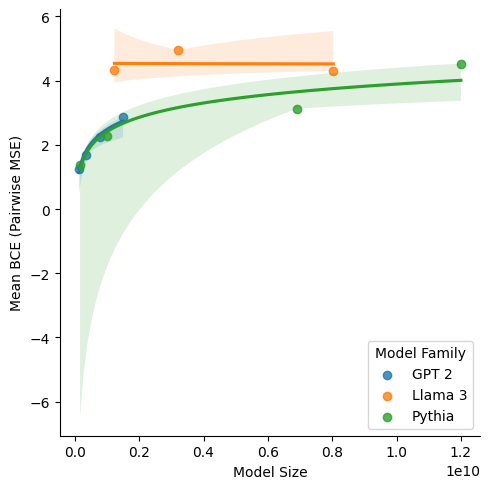

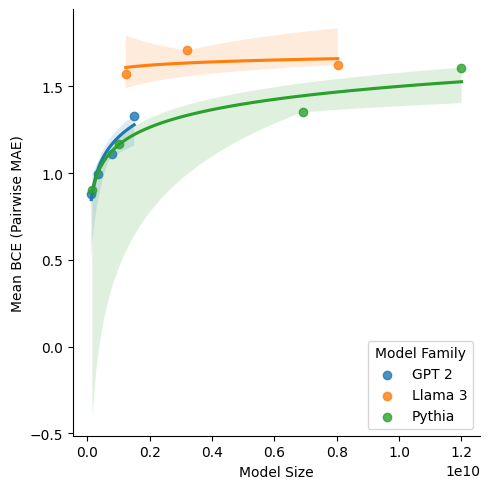

In [11]:
import seaborn as sns

plt = sns.lmplot(
    data=mean_bce_mse_analyzer.df,
    x="Model Size", y="Mean BCE (Pairwise MSE)", hue="Model Family",
    logx=True,
    facet_kws={"legend_out": False},
)

plt = sns.lmplot(
    data=mean_bce_mae_analyzer.df,
    x="Model Size", y="Mean BCE (Pairwise MAE)", hue="Model Family",
    logx=True,
    facet_kws={"legend_out": False}
)

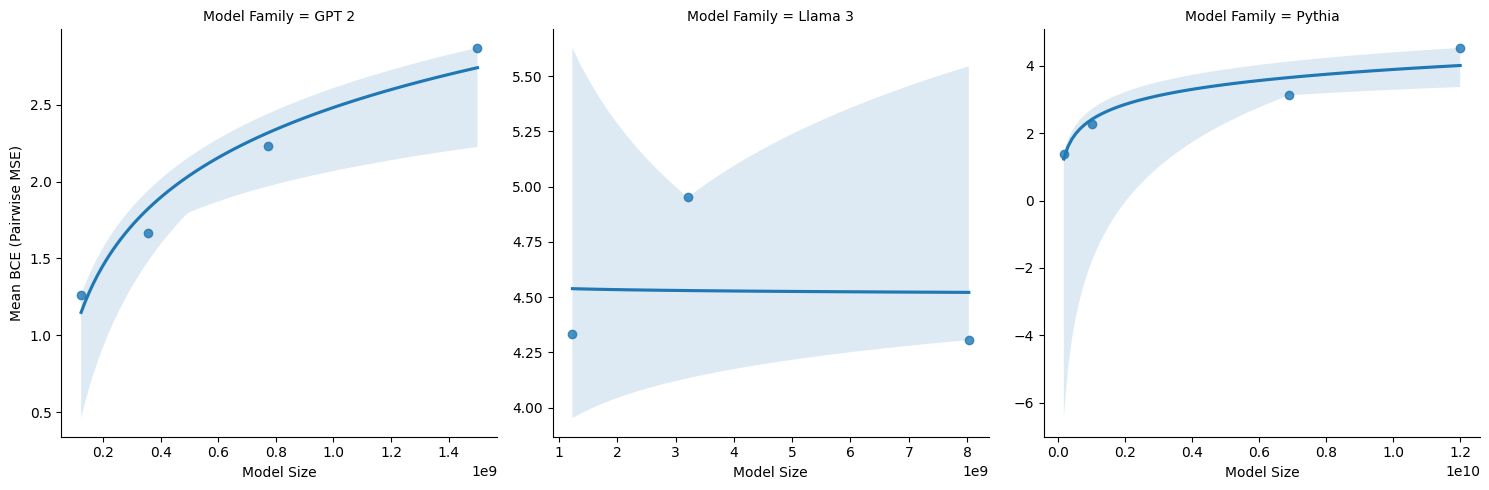

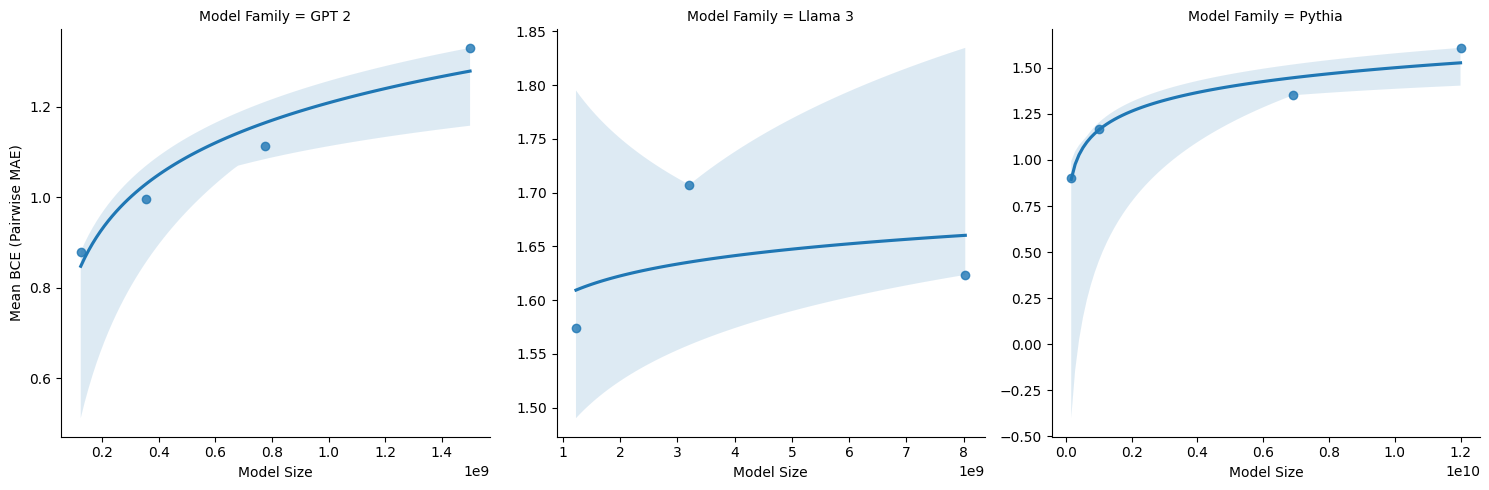

In [12]:
import seaborn as sns

plt = sns.lmplot(
    data=mean_bce_mse_analyzer.df,
    x="Model Size", y="Mean BCE (Pairwise MSE)", col="Model Family",
    logx=True,
    facet_kws={"sharex": False, "sharey": False},
)

plt = sns.lmplot(
    data=mean_bce_mae_analyzer.df,
    x="Model Size", y="Mean BCE (Pairwise MAE)", col="Model Family",
    logx=True,
    facet_kws={"sharex": False, "sharey": False}
)

## Plotting with matplotlib

Unfortunately, seaborn only allows for linear fits, which appear curved in the log scale plot. We can use matplotlib to fit a log-linear model.

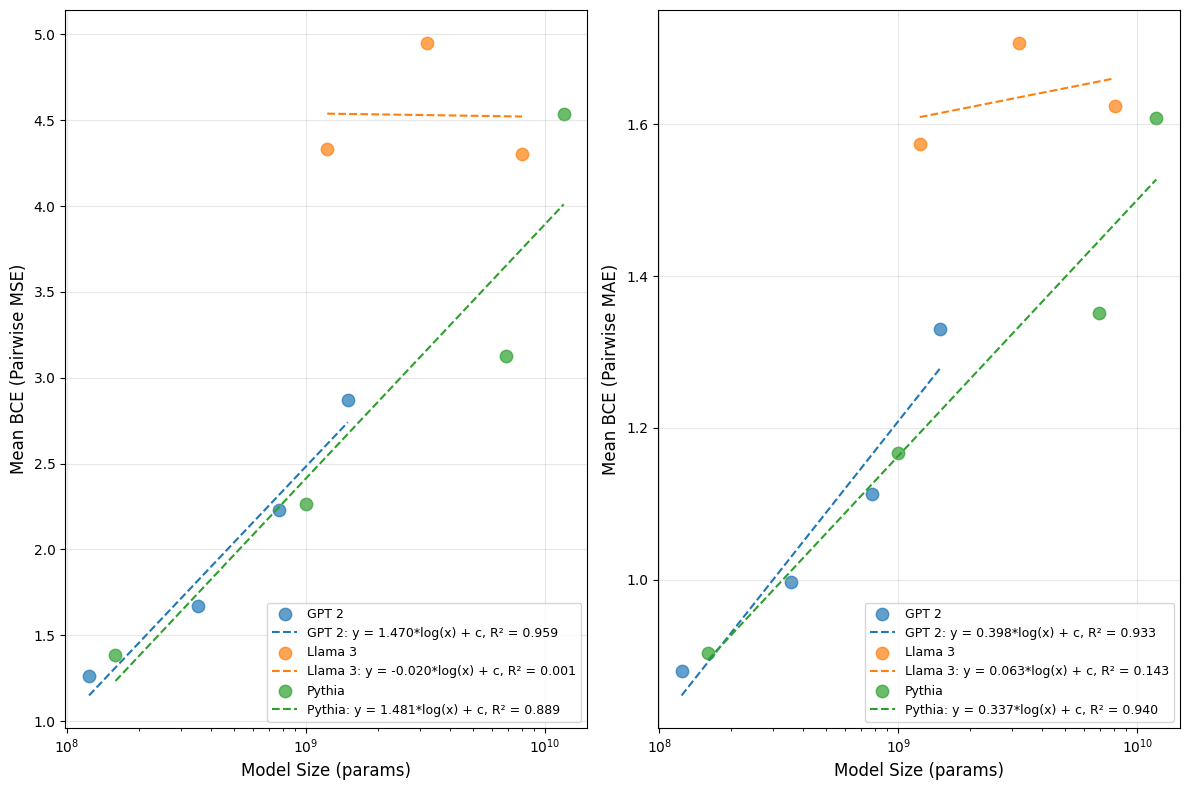

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Function to fit log-linear model
def log_linear_fit(data, x_col, y_col, model_family=None):
    if model_family:
        data = data[data["Model Family"] == model_family]
    
    x = np.log10(data[x_col])  # Log transform x values
    y = data[y_col]
    
    # Fit linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Calculate line
    x_range = np.linspace(min(x), max(x), 100)
    y_range = slope * x_range + intercept
    
    # Transform x back to original scale for plotting
    x_range_original = 10**x_range
    
    return x_range_original, y_range, r_value**2, slope

# Create plots with fitted log-linear relationships
plt.figure(figsize=(12, 8))
for i, (analyzer, title) in enumerate([(mean_bce_mse_analyzer, "Mean BCE (Pairwise MSE)"), 
                                       (mean_bce_mae_analyzer, "Mean BCE (Pairwise MAE)")]):
    plt.subplot(1, 2, i+1)
    
    # Plot points
    for model_family in np.unique(analyzer.df["Model Family"]):
        family_data = analyzer.df[analyzer.df["Model Family"] == model_family]
        plt.scatter(family_data["Model Size"], family_data[title], 
                   label=model_family, alpha=0.7, s=80)
        
        # Add fitted line
        x_line, y_line, r2, slope = log_linear_fit(family_data, "Model Size", title)
        plt.plot(x_line, y_line, '--', 
                 label=f"{model_family}: y = {slope:.3f}*log(x) + c, R² = {r2:.3f}")
    
    plt.xscale('log')
    plt.xlabel("Model Size (params)", fontsize=12)
    plt.ylabel(title, fontsize=12)
    plt.legend(fontsize=9, loc='best')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()